In [43]:
import pandas as pd
import numpy as np
from rdkit import Chem
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from featurizer import *
from models import *


In [2]:
# Load Data

df_all = pd.read_csv('data.csv')
df_all.head()

,smiles,target1,target2,target3,target4,target5,target6,target7,target8,target9,target10,target11,target12
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


In [3]:
df_all.shape

(8014, 13)

In [20]:
target = 'target1'

## Convolutional Neural Network

In [21]:
# Separate data with known and unknown values

df = df_all[['smiles', target]]
known = df.loc[~df[target].isna()]
unknown = df.loc[df[target].isna()]

X_known = known["smiles"].values.tolist()
y_known = known[target].values.tolist()

X_unknown = unknown["smiles"].values.tolist()
y_unknown = unknown[target].values.tolist()

In [22]:
# Featurize SMILES

F = []
for i in range(len(X_known)):
    mol = Chem.MolToSmiles(Chem.MolFromSmiles(X_known[i]), kekuleSmiles=True)
    f = mol_feature(mol)
    smiles_matrix = np.reshape(f, (400,27,1))
    F.append(smiles_matrix)
F = np.array(F)

Fu = []
for i in range(len(X_unknown)):
    mol = Chem.MolToSmiles(Chem.MolFromSmiles(X_unknown[i]), kekuleSmiles=True)
    fu = mol_feature(mol)
    smiles_matrix = np.reshape(fu, (400,27,1))
    Fu.append(smiles_matrix)
Fu = np.array(Fu)

In [23]:
# Train and Test Split

X_train, X_test, y_train, y_test = train_test_split(F, y_known, test_size=0.2, random_state=1)

In [24]:
# Predict outputs with CNN 

cnn_test_probs, cnn_preds = cnn_model(X_train, y_train, X_test, y_test, Fu, nepochs=1, shape=(400, 27, 1))

Train on 5951 samples, validate on 1488 samples
Epoch 1/1
5951/5951 [==============================] - 256s 43ms/step - loss: 0.1954 - acc: 0.9534 - val_loss: 0.1313 - val_acc: 0.9651


('ROC-AUC:', 0.7446767195200342)


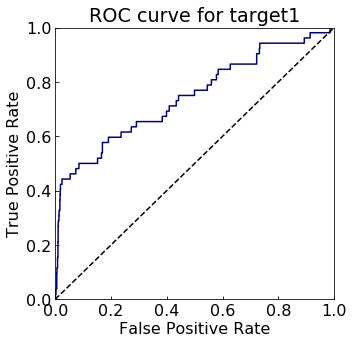

In [25]:
# Plot ROC curve

fpr, tpr, thresholds = metrics.roc_curve(np.squeeze(y_test), np.squeeze(cnn_test_probs[:,1]), pos_label=1)
auc = metrics.auc(fpr, tpr)
print ('ROC-AUC:', auc)

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr,  color = 'navy')
plt.plot((0,1), (0,1), '--', color = 'black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,1.0)
plt.ylim(0,1.0)
plt.title('ROC curve for target1')
plt.tick_params(direction='in')

plt.show()

## SMILES Sequence Feature Extraction

In [6]:
# Separate data with known and unknown values

known = df.loc[~df[target].isna()]
unknown = df.loc[df[target].isna()]
known_idx = list(known.index)
unknown_idx = list(unknown.index)
smiles_list = df.smiles.tolist()

In [7]:
# Featurize 

result = featurize_smiles_ngram(smiles_list)
X_known = result['feature_array'].todense()[known_idx,:]
X_unknown = result['feature_array'].todense()[unknown_idx,:]

Y_known = df[target].iloc[known_idx]

vectorizer = result['vectorizer']
vocab = vectorizer.vocabulary_
feature_names = vectorizer.get_feature_names()

In [8]:
# Detect Important Features

feature_importance = entopy_feature_importance(X_known, Y_known, vocab, feature_names)
feature_importance.head(10)


,Feature,MutualInfo,FeatureIndex
0,4=C,0.047837,7884
1,C4=C,0.047034,11262
2,C[C@],0.046923,12825
3,4=CC,0.045464,7893
4,@],0.044760,9555
5,C[C,0.044536,12821
6,C[C@,0.044335,12822
7,C[,0.044177,12815
8,4=,0.041994,7883
9,@]1,0.041321,9572


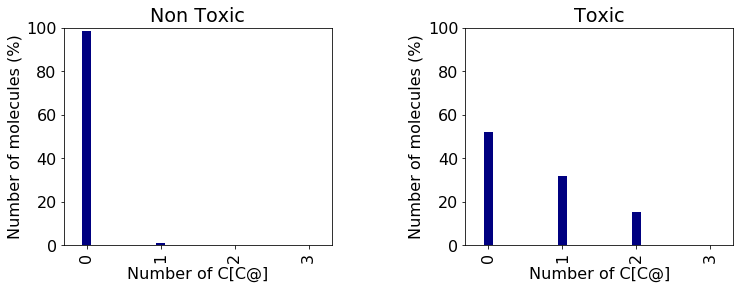

In [10]:
# Plot Important Feature Frequency

# target 1

s = 'C[C@]'

z = pd.DataFrame()
z['x'] = X_known[:,vocab[s]].reshape((X_known.shape[0],)).tolist()[0]
z['y'] = Y_known.values

z0 = z.loc[z.y == 0].x.value_counts()/z.loc[z.y == 0].shape[0]*100
z1 = z.loc[z.y == 1].x.value_counts()/z.loc[z.y == 1].shape[0]*100

plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.subplots_adjust(wspace=0.5)

z0.plot(kind = 'bar', color = 'navy', width = 0.12, ax = axes[0], title='Non Toxic')
z1.plot(kind = 'bar', color = 'navy', width = 0.12, ax = axes[1], title='Toxic')

for i in [0,1]:
    axes[i].set_xlabel('Number of '+s+'',size = 16)
    axes[i].set_ylabel('Number of molecules (%)',size = 16)
    axes[i].set_ylim(0,100)

plt.show()

In [11]:
# Train and Test Split

important_features = feature_importance.head(5000).FeatureIndex.tolist()

X_train, X_test, y_train, y_test = train_test_split(X_known[:,important_features], 
                                                    Y_known, 
                                                    test_size=0.2, 
                                                    random_state=98)

In [12]:
# Apply SVM

svm_result = svm_model(df, unknown_idx, important_features, X_train, y_train, X_test, X_unknown)

/Users/soran/opt/anaconda3/envs/deepchem/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
models.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  result['SVM_ToxicProb'] = svm_model.predict_proba(X_unknown[:,important_features])[:, 1]


In [13]:
svm_test_probs = svm_result[0]
svm_preds = svm_result[1]

In [14]:
svm_preds.head()

,smiles,SVM_ToxicProb
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,0.567683
9,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2],0.015162
19,CCOC(=O)c1cccnc1,0.016228
48,Nc1ccccc1C(=O)Oc1ccc2ccccc2c1,0.018948
80,COc1ccc(C2C(=O)c3ccccc3C2=O)cc1,0.017264


('ROC-AUC:', 0.81)


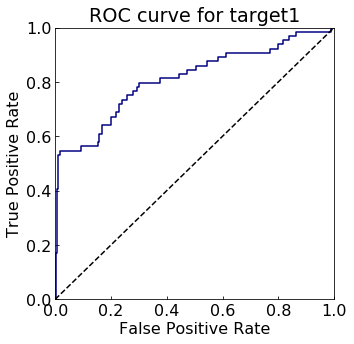

In [16]:
# Plot ROC Curve

threshold = 0.4
probs = svm_test_probs

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
auc = round(metrics.auc(fpr, tpr), 3)

print ('ROC-AUC:', auc)

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr,  color = 'navy')
plt.plot((0,1), (0,1), '--', color = 'black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,1.0)
plt.ylim(0,1.0)
plt.title('ROC curve for target1')
plt.tick_params(direction='in')

plt.show()


## Singular Value Decomposition

In [17]:
# Apply SVD

svd_preds = svd_model(df_all)

RMSE: 0.2497
RMSE of SVD model for cross validation0.25
RMSE: 0.2460
RMSE of SVD model for cross validation0.246
RMSE: 0.2391
RMSE of SVD model for cross validation0.239


In [18]:
svd_preds.head()

,smiles,Target,ToxicProb
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,target1,0.009387
9,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2],target1,0.047888
19,CCOC(=O)c1cccnc1,target1,0.040683
48,Nc1ccccc1C(=O)Oc1ccc2ccccc2c1,target1,0.085996
80,COc1ccc(C2C(=O)c3ccccc3C2=O)cc1,target1,0.007916


In [29]:
len (svm_preds)

575

## Final Results

In [44]:
# Present All Model Predictions
# target1

result = svd_preds.head(575)
result['SVD'] = svd_preds['ToxicProb']
result['SVM'] = svm_preds['SVM_ToxicProb']
result['CNN'] = list(cnn_preds[:,1])
result = result.drop('ToxicProb', axis=1)

/Users/soran/opt/anaconda3/envs/deepchem/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/soran/opt/anaconda3/envs/deepchem/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/soran/opt/anaconda3/envs/deepchem/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [47]:
# Print Final Result
# target1

result

,smiles,Target,SVD,SVM,CNN
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,target1,0.009387,0.567683,0.296087
9,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2],target1,0.047888,0.015162,0.100636
19,CCOC(=O)c1cccnc1,target1,0.040683,0.016228,0.005593
48,Nc1ccccc1C(=O)Oc1ccc2ccccc2c1,target1,0.085996,0.018948,0.014797
80,COc1ccc(C2C(=O)c3ccccc3C2=O)cc1,target1,0.007916,0.017264,0.031275
87,CCN1CCc2nc(N)oc2CC1,target1,0.010389,0.018895,0.013931
90,O=c1[nH]c(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1...,target1,0.002354,0.054722,0.075871
115,O=C(CO)[C@@H](O)[C@H](O)[C@@H](O)CO,target1,0.032092,0.031913,0.042644
117,CNCC(=O)c1ccc(O)c(O)c1,target1,0.008599,0.023285,0.011159
124,Nc1ccncc1N,target1,0.031314,0.016674,0.014655
